In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import torch
from acctrack.tools.model_inference import ModelLoader, TorchModelInference
from acctrack.io.pyg_data_reader import TrackGraphDataReader
from acctrack.tools.utils_graph import build_edges
from acctrack.tools.edge_perf import EdgePerformance
import faiss
from pathlib import Path
from acctrack.viewer.classification import plot_metrics
import numpy as np
import onnxruntime as ort

uproot is not installed. AthenaRawRootReader will not be available.


## General Configurations

In [4]:
base_path = "/global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/"
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
embedding_model_path = base_path + "/TrainedModels/v1/graph_construction-MetricLearning-v1.pt"
filtering_model_path = base_path + "/TrainedModels/v1/edge_classifier-PermutationInvariantFilter-v1.pt"
gnn_onnx_path = base_path + "/TrainedModels/v1/edge_classifier-DirectionalGNN-v1.onnx"
data_path = base_path + "/2023_uncorr_feature_store"
data_type = "trainset"

r_max, k_max = 0.1, 1000
knn_backend = "FAISS-CPU-Flatl2"
config_file = "exatrkx_inference.yaml"
embedding_file_name = "embedding.pt"

## Compare Embedding

In [110]:
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
model_inference = TorchModelInference(config_file, data_type, model_path, ".", name="v2")
results = model_inference.inference(0, knn_backend="FRNN")

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v2/graph_construction-MetricLearning-v1.pt
trainset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 182,310, True Edges 216,498, Per-edge efficiency: 84.209%
True Edges 216,498, Reco Edges 13,920,808, Per-edge purity: 1.555%
Only 12.141% of true edges are of interests (signal)
True Reco Signal Edges 26,028, True Signal Edges 26,286, Per-edge signal efficiency: 99.018%


In [111]:
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
model_inference = TorchModelInference(config_file, data_type, model_path, ".", name="v2")
results = model_inference.inference(0, knn_backend="FRNN")

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v2/graph_construction-MetricLearning-v1.pt
trainset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 180,830, True Edges 216,498, Per-edge efficiency: 83.525%
True Edges 216,498, Reco Edges 12,179,298, Per-edge purity: 1.778%
Only 12.141% of true edges are of interests (signal)
True Reco Signal Edges 26,010, True Signal Edges 26,286, Per-edge signal efficiency: 98.950%


In [109]:
model_path = base_path + "/TrainedModels/v2/graph_construction-MetricLearning-v1.pt"
model_inference = TorchModelInference(config_file, "valset", model_path, ".", name="v2")
results = model_inference.inference(0, knn_backend="FRNN")

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v2/graph_construction-MetricLearning-v1.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset/event000008899-graph.pyg
True Reco Edges 199,642, True Edges 237,602, Per-edge efficiency: 84.024%
True Edges 237,602, Reco Edges 17,408,606, Per-edge purity: 1.365%
Only 13.104267% of true edges are of interests (signal)
True Reco Signal Edges 30,738, True Signal Edges 31,136, Per-edge signal efficiency: 98.722%


In [56]:
print(model_inference.data_reader_training.data.keys)

['norm_y_2', 'particle_id', 'charge_count_2', 'radius', 'event_id', 'charge_count_1', 'eta_angle_1', 'redundant_split_edges', 'glob_eta_2', 'phi', 'localDir2_2', 'localDir2_1', 'eta', 'count_2', 'region', 'localDir0_1', 'y', 'lengthDir1_2', 'norm_x_1', 'pdgId', 'hit_id', 'nhits', 'x', 'glob_eta_1', 'cluster_z_1', 'r', 'lengthDir2_1', 'count_1', 'lengthDir0_2', 'norm_z_1', 'z', 'cluster_x_2', 'pt', 'track_edges', 'loc_phi_1', 'cluster_y_1', 'norm_y_1', 'localDir1_1', 'lengthDir0_1', 'eta_angle_2', 'cluster_z_2', 'lengthDir1_1', 'glob_phi_2', 'norm_z_2', 'norm_x_2', 'lengthDir2_2', 'primary', 'config', 'phi_angle_2', 'localDir0_2', 'phi_angle_1', 'cluster_y_2', 'loc_phi_2', 'cluster_x_1', 'localDir1_2', 'loc_eta_1', 'loc_eta_2', 'glob_phi_1']


In [60]:
model_inference.data_reader_training.data['y']

tensor([   7.8250,   -1.4750,   -7.8250,  ..., -106.8120, -145.1290,
        -138.7780], dtype=torch.float64)

In [97]:
model_path = base_path + "/TrainedModels/v1/graph_construction-MetricLearning-v5-pl.pt"
model_inference = TorchModelInference(config_file, model_path, ".", name="v5-pl")
res_v5_pl = model_inference.inference(0, knn_backend="FRNN")

Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/testset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 181,084, True Edges 216,498, Per-edge efficiency: 83.642%
True Edges 216,498, Reco Edges 99,972,562, Per-edge purity: 0.217%
Only 12.141452% of true edges are of interests (signal)
True Reco Signal Edges 23,951, True Signal Edges 26,286, Per-edge signal efficiency: 91.117%


## Explore Data

In [4]:
data_path = base_path + "/metric_learning_testing/trainset"
reader = TrackGraphDataReader(data_path, name="Embedding")
data = reader.read(0)

Embedding: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset/event000001693.pyg


In [5]:

data_path = "/pscratch/sd/x/xju/ITk/ForFinalPaper/Results/Training/v1/directionalGNN_v1/trainset/"
reader = TrackGraphDataReader(data_path, name="GNN")
data = reader.read(0)

ValueError: invalid literal for int() with base 10: "['000006930']"

In [18]:
data

DataBatch(lengthDir1_1=[275435], localDir1_2=[275435], x=[275435], cluster_z_2=[275435], norm_z_1=[275435], lengthDir2_1=[275435], loc_phi_2=[275435], loc_eta_1=[275435], eta_angle_2=[275435], count_2=[275435], glob_phi_1=[275435], r=[275435], cluster_y_1=[275435], localDir1_1=[275435], norm_y_2=[275435], norm_x_2=[275435], localDir2_2=[275435], charge_count_2=[275435], hit_id=[275435], count_1=[275435], loc_eta_2=[275435], lengthDir0_2=[275435], cluster_x_2=[275435], lengthDir0_1=[275435], phi_angle_2=[275435], lengthDir1_2=[275435], glob_eta_2=[275435], phi=[275435], glob_eta_1=[275435], loc_phi_1=[275435], eta_angle_1=[275435], cluster_x_1=[275435], y=[8418480], localDir0_2=[275435], eta=[275435], norm_z_2=[275435], phi_angle_1=[275435], lengthDir2_2=[275435], cluster_z_1=[275435], cluster_y_2=[275435], norm_y_1=[275435], localDir0_1=[275435], region=[275435], localDir2_1=[275435], glob_phi_2=[275435], norm_x_1=[275435], charge_count_1=[275435], z=[275435], track_edges=[2, 108249], 

In [17]:
data.particle_id.shape, data.truth_map.shape, data.x.shape, 

(torch.Size([108249]), torch.Size([108249]), torch.Size([275435]))

In [12]:
pidx = data.particle_id == 515
hits = data.truth_map[pidx]

In [26]:
hit_idx = np.isin(data.hit_id.cpu().numpy(), hits)
hit_idx.shape

(275435,)

In [29]:
data.hit_id

tensor([     0,      1,      2,  ..., 275432, 275433, 275434])

In [11]:
data.particle_id.unique()[0:10]

tensor([512, 515, 540, 543, 566, 579, 581, 582, 583, 587])

In [31]:
sentences = 'Donald Trump was charged with four federal counts related to his efforts to overturn the 2020 presidential election and the January 6th attack on the Capitol. The charges—brought by Jack Smith, an independent special counsel—accuse the former president of conspiring to defraud America, to obstruct an “official proceeding” (the certification of the vote) and to deprive people of their right to vote and have their vote counted. Mr Trump dismissed the charges as a Fake Indictment'
words = sentences.split()
import random
random_words = random.shuffle(words)
print(words)

['to', 'president', 'the', 'federal', 'with', 'certification', '6th', 'proceeding”', 'charges—brought', 'and', 'Mr', 'by', 'Trump', 'America,', 'was', 'his', 'deprive', 'vote', '(the', 'independent', 'have', 'of', 'overturn', 'charged', 'their', 'obstruct', 'attack', 'counts', 'defraud', 'Smith,', 'related', 'dismissed', 'Jack', 'to', 'Trump', 'The', '“official', 'the', 'charges', 'efforts', 'election', 'Indictment', 'Donald', 'Fake', 'on', 'to', 'vote', 'an', 'counsel—accuse', 'and', 'a', 'counted.', '2020', 'four', 'and', 'presidential', 'the', 'their', 'right', 'the', 'vote)', 'of', 'the', 'the', 'people', 'as', 'January', 'an', 'of', 'to', 'former', 'conspiring', 'Capitol.', 'special', 'to', 'to']


## Inference Pipeline

In [6]:
data_path = base_path + "/metric_learning_testing/trainset"
reader = TrackGraphDataReader(data_path, name="Embedding")
data = reader.read(0)

Embedding: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset/event000001693.pyg


In [29]:
import yaml
with open(config_file, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [8]:
econfig = config["embedding"]
node_features = econfig["node_features"]
node_scales = econfig["node_scales"]

features = reader.get_node_features(node_features, node_scales)

In [9]:
embedding_model_path = config['embedding']["model_path"]
embedding = torch.jit.load(embedding_model_path)
embedding.eval()

RecursiveScriptModule(
  original_name=MetricLearning
  (network): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=LayerNorm)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=LayerNorm)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=Linear)
    (10): RecursiveScriptModule(original_name=LayerNorm)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Linear)
  )
)

In [10]:
embedding_features = embedding.forward(features)

In [11]:
edge_index = build_edges(embedding_features, r_max=r_max, k_max=k_max, backend="FRNN")

In [12]:
edge_index.device

device(type='cuda', index=0)

In [13]:
filtering_model = torch.jit.load(filtering_model_path, map_location=torch.device('cuda'))
filtering_model.eval()

RecursiveScriptModule(
  original_name=PermutationInvariantFilter
  (encoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=LayerNorm)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=LayerNorm)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=Linear)
    (10): RecursiveScriptModule(original_name=LayerNorm)
    (11): RecursiveScriptModule(original_name=ReLU)
  )
  (decoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=ReLU

In [14]:
fconfig = config['filtering']
filter_node_features = fconfig["node_features"]
filter_node_scales = fconfig["node_scales"]
filter_data_features = reader.get_node_features(filter_node_features, filter_node_scales)

In [15]:
filter_data_features.shape, filter_data_features.device, edge_index.shape, edge_index.device

(torch.Size([275435, 25]),
 device(type='cpu'),
 torch.Size([2, 12688584]),
 device(type='cpu'))

In [15]:
senders, receivers = filter_data_features[edge_index[0]], filter_data_features[edge_index[1]]

In [19]:
device = 'cuda'
senders = senders.to(device)
receivers = receivers.to(device)

In [16]:
from acctrack.tools.model_inference import batched_inference

In [20]:
filtering_edge_scores = batched_inference(filtering_model, senders, receivers, batch_size=1_000_000)

In [19]:
with torch.no_grad():
    batch_size = 1024
    filtering_edge_scores = filtering_model.forward(senders[:batch_size], receivers[:batch_size])

In [22]:
filtering_edge_scores = torch.sigmoid(filtering_edge_scores)

In [23]:
threshold = 0.57
filtering_selections = filtering_edge_scores > threshold
edge_index_after_filter = edge_index[:, filtering_selections]

In [24]:
edge_index_after_filter.shape

torch.Size([2, 2571692])

In [30]:
g_config = config.get('gnn', None)
node_features = g_config['node_features']
node_scales = g_config['node_scales']
features = reader.get_node_features(node_features, node_scales)

In [33]:
edge_index_after_filter

tensor([[     0,      1,      1,  ..., 275434, 275434, 275434],
        [    82,  14316,  14326,  ..., 271519, 271534, 271540]],
       device='cuda:0')

In [66]:
import onnx
onnx_model = onnx.load(gnn_onnx_path)
onnx.checker.check_model(onnx_model)

In [88]:
session = ort.InferenceSession(gnn_onnx_path, providers=['CUDAExecutionProvider'])
output = np.zeros(edge_index_after_filter.shape[1], dtype=np.float32)
gnn_output = session.run(None, 
                         {"x": features.cpu().numpy(), 
                          "edge_index": edge_index_after_filter.cpu().numpy()})

In [85]:
gnn_output[0], features

(array([[ 0.03337711, -0.99692905, -0.08833333, ..., -0.75037897,
          0.41635   ,  1.24905   ],
        [ 0.03405646,  0.9399043 , -0.08833333, ..., -0.75037897,
          0.327598  ,  0.982794  ],
        [ 0.03345403, -0.9918591 , -0.08833333, ..., -0.75037897,
          0.327598  ,  0.982794  ],
        ...,
        [ 0.94284904, -0.03746629,  0.9514167 , ...,  0.45214328,
          0.44154668,  0.00637931],
        [ 0.9620676 , -0.03931001,  0.9514167 , ...,  0.45214328,
          0.44154668,  0.00637931],
        [ 0.95497763, -0.06019103,  0.9514167 , ...,  0.45214328,
          0.44154668,  0.00637931]], dtype=float32),
 tensor([[ 0.0334, -0.9969, -0.0883,  ..., -0.7504,  0.4164,  1.2491],
         [ 0.0341,  0.9399, -0.0883,  ..., -0.7504,  0.3276,  0.9828],
         [ 0.0335, -0.9919, -0.0883,  ..., -0.7504,  0.3276,  0.9828],
         ...,
         [ 0.9428, -0.0375,  0.9514,  ...,  0.4521,  0.4415,  0.0064],
         [ 0.9621, -0.0393,  0.9514,  ...,  0.4521,  0.4415,

## Exam scattering

Each node may be connected to `n` number of edges and each edge may have `m` features. The goal is to *aggregate* the edge features for each node, which will result in a `1 x m` vector for each node. The aggregation function can be mean, sum, max, etc. In this example, we will use sum.

In [188]:
num_e = 20
num_e_features = 5
num_v = 10
torch.random.manual_seed(42)
edge_features = torch.rand((num_e_features, num_e))
random_edge_indices = torch.randint(0, num_v, (2, num_e))

# the node in question is a sender
senders = random_edge_indices[0:1, :]
senders = senders.tile(num_e_features, 1)

results = torch.zeros(num_e_features, num_v, dtype=edge_features.dtype)
results = results.scatter_add(1, senders, edge_features).T
results


tensor([[2.5088, 1.1852, 1.9365, 0.6992, 1.3370],
        [2.3046, 2.2934, 2.1995, 2.1434, 2.3420],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9150, 0.4414, 0.3644, 0.1587, 0.1591],
        [0.5936, 0.0753, 0.3068, 0.6666, 0.3725],
        [3.0912, 2.6892, 2.4940, 2.3940, 1.9373],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.5670, 0.6016, 2.0889, 1.5110, 1.6803],
        [0.7606, 0.3485, 0.3400, 1.1172, 0.6686],
        [1.0033, 1.7130, 1.1984, 0.8113, 0.5643]])

In [197]:
edge_features = torch.rand((num_e,num_e_features))
random_edge_indices = torch.randint(0, num_v, (2, num_e))
senders = random_edge_indices[0:1, :]
senders = senders.tile(num_e_features, 1).T

results = torch.zeros(num_v, num_e_features, dtype=edge_features.dtype)
results = results.scatter_add(0, senders, edge_features)

In [199]:
results

tensor([[1.6229, 1.0722, 0.9872, 1.4357, 0.4548],
        [1.3313, 1.7635, 1.2490, 1.3414, 1.3200],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.0056, 0.8538, 1.1922, 1.7726, 1.0956],
        [0.8989, 0.4269, 0.5095, 0.7985, 0.9347],
        [1.2984, 1.6955, 1.9325, 2.4139, 1.2235],
        [1.8800, 1.8058, 2.1856, 1.4639, 1.9251],
        [0.0343, 0.3092, 0.0702, 0.1836, 0.7785],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6100, 1.0941, 0.8844, 0.7959, 0.8228]])

### agrr in pyg

In [174]:
from torch_geometric.nn import aggr
sum_aggr = aggr.SumAggregation()

In [179]:
edge_features.shape, random_edge_indices.shape

(torch.Size([5, 20]), torch.Size([2, 20]))

In [180]:
sum_aggr(edge_features.T, random_edge_indices[0])

tensor([[2.5088, 1.1852, 1.9365, 0.6992, 1.3370],
        [2.3046, 2.2934, 2.1995, 2.1434, 2.3420],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9150, 0.4414, 0.3644, 0.1587, 0.1591],
        [0.5936, 0.0753, 0.3068, 0.6666, 0.3725],
        [3.0912, 2.6892, 2.4940, 2.3940, 1.9373],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.5670, 0.6016, 2.0889, 1.5110, 1.6803],
        [0.7606, 0.3485, 0.3400, 1.1172, 0.6686],
        [1.0033, 1.7130, 1.1984, 0.8113, 0.5643]])

In [41]:
edge_perf = EdgePerformance(reader)

In [43]:
truth_labels, true_edges, per_edge_efficiency, per_edge_purity = edge_perf.eval(edge_index)

True Reco Edges 163,492, True Edges 216,498, Per-edge efficiency: 75.517%
True Edges 216,498, Reco Edges 12,688,452, Per-edge purity: 1.706%
Only 12.141% of true edges are of interests (signal)
True Reco Signal Edges 26,194, True Signal Edges 26,286, Per-edge signal efficiency: 99.650%


                     0.10    0.50    0.80
Accuracy:            0.5795 0.7861 0.8803
Precision (purity):  0.0292 0.0513 0.0795
Recall (efficiency): 0.9804 0.8926 0.7838
AUC: 0.9264
Purity at 0.0248 efficiency: 0.9900 with cut 0.0524


(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: xlabel='Model output'>,
        <Axes: title={'center': 'ROC curve, AUC = 0.9264'}, xlabel='False positive rate', ylabel='True positive rate'>,
        <Axes: xlabel='Cut on model score'>,
        <Axes: xlabel='Purity', ylabel='Efficiency'>], dtype=object),
 0.9263716055843011,
 0.9900056271866513,
 0.024800692577014716,
 0.05240802)

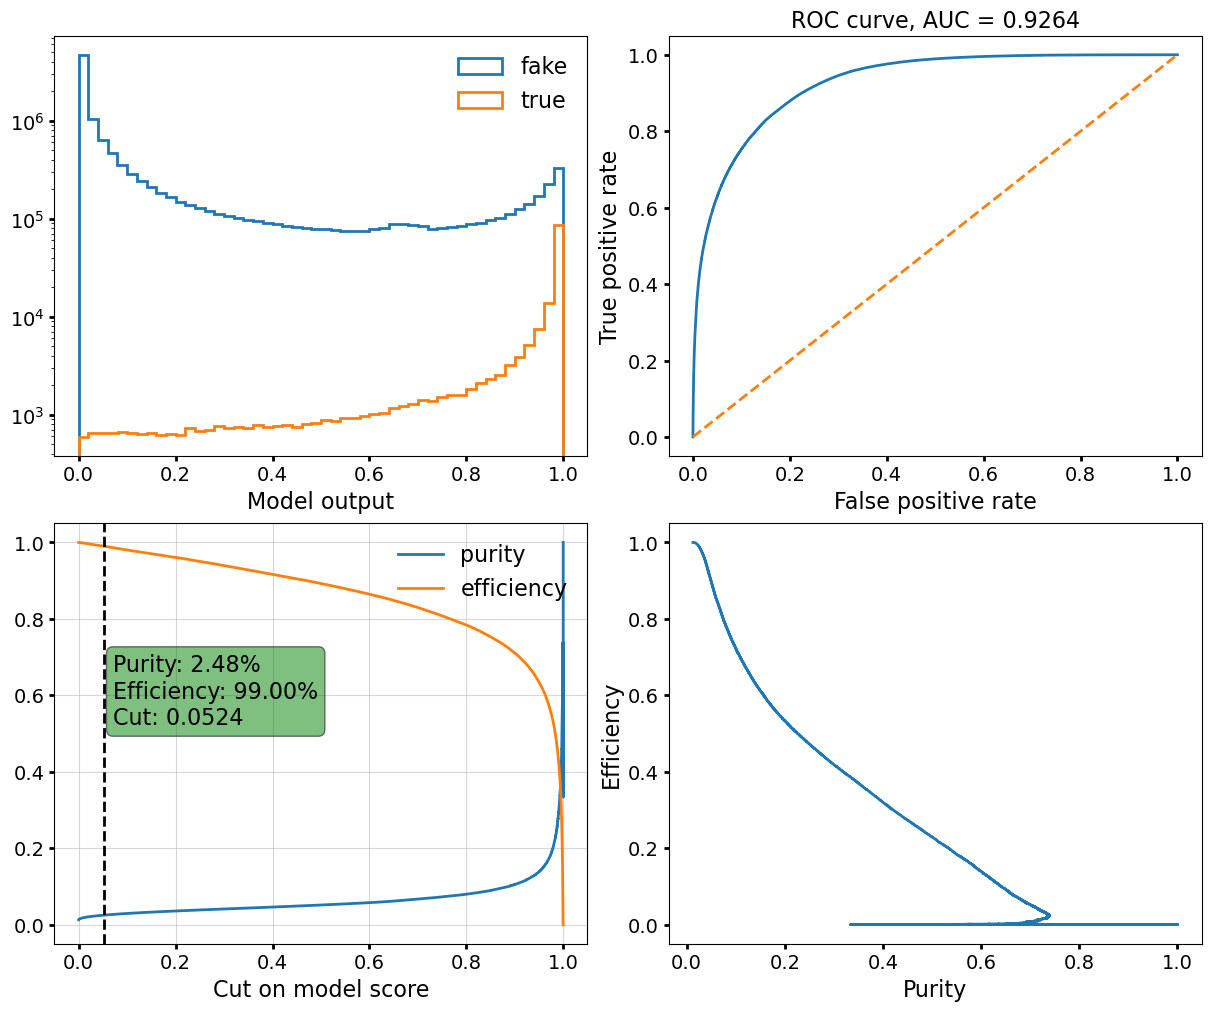

In [44]:
edge_perf.eval_edge_scores(filtering_edge_scores, truth_labels, outname="perf_filtering_evt{}".format(0))

In [50]:
edge_perf.eval_edge_scores(gnn_output, truth_labels[filtering_selections], 
                           outname="perf_filtering_evt{}".format(0))

ValueError: Found input variables with inconsistent numbers of samples: [2571692, 275435]

In [42]:
batch_size = 1024
filtering_edge_scores = filtering_model.forward(senders[:batch_size], receivers[:batch_size])
filtering_edge_scores

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612],
       grad_fn=<DifferentiableGraphBackward>)

In [39]:
filtering_edge_scores

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612],
       grad_fn=<SqueezeBackward1>)

In [38]:
filtering_edge_scores.detach()

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612])

In [36]:
jj = torch.concat([filtering_edge_scores, filtering_edge_scores], dim=0)
jj.shape

torch.Size([2048])

In [37]:
jj

tensor([ 2.9057, -0.6808,  1.4122,  ...,  1.7383, -1.4039,  1.5612],
       grad_fn=<CatBackward0>)

In [70]:
data.y.shape, data.edge_index.shape, data.track_edges.shape, data.pt.shape, data.nhits.shape

(torch.Size([8418480]),
 torch.Size([2, 8418480]),
 torch.Size([2, 108249]),
 torch.Size([108249]),
 torch.Size([108249]))

In [83]:
data.track_edges[0, data.track_edges[0] > 109249]

tensor([109251, 109254, 109256,  ..., 271532, 271533, 273373])

In [91]:
data.phi.shape, data.pt.shape, data.eta_angle_2.shape, data.particle_id.shape, data.pdgId.shape

(torch.Size([275435]),
 torch.Size([108249]),
 torch.Size([275435]),
 torch.Size([108249]),
 torch.Size([108249]))

In [93]:
data.truth_map.shape

torch.Size([108249])

In [79]:
max(data.track_edges[0]), max(data.track_edges[1])

(tensor(273373), tensor(275432))

In [78]:
data.track_edges[0]

tensor([     0,      3,      4,  ..., 271532, 271533, 273373])

In [71]:
data.primary

tensor([1., 1., 1.,  ..., 1., 1., 0.], dtype=torch.float64)

## Compare different trained Embedding models

In [100]:
version = 'v1'
model_files = {
    "v1": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v1.pt",
    "v2": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v2.pt",
    "v3": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v3.pt",
    "v4": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v4.pt",
    "v5": base_path + f"/TrainedModels/{version}/graph_construction-MetricLearning-v5.pt",
}

In [101]:

models = { k: TorchModelInference(config_file, "trainset", v, ".", name=k) for k, v in model_files.items() }

Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/testset
Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/testset
Training: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset
Validation: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Test: Tota

In [103]:

results = { k: m.inference(0, knn_backend="FRNN") for k,m in models.items() }

Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 163,492, True Edges 216,498, Per-edge efficiency: 75.517%
True Edges 216,498, Reco Edges 12,688,452, Per-edge purity: 1.706%
Only 12.141452% of true edges are of interests (signal)
True Reco Signal Edges 26,194, True Signal Edges 26,286, Per-edge signal efficiency: 99.650%
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 184,712, True Edges 216,498, Per-edge efficiency: 85.318%
True Edges 216,498, Reco Edges 29,230,107, Per-edge purity: 0.741%
Only 12.141452% of true edges are of interests (signal)
True Reco Signal Edges 26,068, True Signal Edges 26,286, Per-edge signal efficiency: 99.171%
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/trainset/event000001693-graph.pyg
True Reco Edges 174,589, True Edges 216,498, 

### How about validation dataset?

In [104]:

models = { k: TorchModelInference(config_file, "valset", v, ".", name=k) for k, v in model_files.items() }
results = { k: m.inference(0, knn_backend="FRNN") for k,m in models.items() }

Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v1.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v2.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v3.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Loading model from /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper//TrainedModels/v1/graph_construction-MetricLearning-v4.pt
valset: Total 1 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/2023_uncorr_feature_store/valset
Load

## Verify graph intersections

In [19]:
edge_index = torch.tensor([[1, 3], [2, 3], [2, 4], [3, 4], [1, 4], [3, 1]], dtype=torch.long).T
true_edges = torch.tensor([[1, 2], [2, 3], [3, 1]], dtype=torch.long).T

In [20]:
edge_index.shape

torch.Size([2, 6])

In [21]:
unique_edges, inverse = torch.unique(torch.cat([edge_index, true_edges], dim=1), dim=1, sorted=False, return_inverse=True, return_counts=False)


In [23]:
unique_edges, inverse

(tensor([[1, 1, 1, 2, 2, 3, 3],
         [2, 3, 4, 3, 4, 1, 4]]),
 tensor([1, 3, 4, 6, 2, 5, 0, 3, 5]))

In [24]:
inverse_pred_map = torch.ones_like(unique_edges[1]) * -1
inverse_pred_map

tensor([-1, -1, -1, -1, -1, -1, -1])

In [25]:
inverse_pred_map[inverse[:edge_index.shape[1]]] = torch.arange(edge_index.shape[1])

In [26]:
inverse_pred_map

tensor([-1,  0,  4,  1,  2,  5,  3])

In [27]:
inverse_truth_map = torch.ones_like(unique_edges[1]) * -1
inverse_truth_map[inverse[edge_index.shape[1]:]] = torch.arange(true_edges.shape[1])

In [28]:
inverse_truth_map

tensor([ 0, -1, -1,  1, -1,  2, -1])

In [34]:
inverse_truth_map[inverse]

tensor([-1,  1, -1, -1, -1,  2,  0,  1,  2])

In [35]:
pred_to_truth = inverse_truth_map[inverse[:edge_index.shape[1]]]
truth_to_pred = inverse_pred_map[inverse][edge_index.shape[1]:]

In [32]:
inverse.shape, inverse_truth_map.shape

(torch.Size([9]), torch.Size([7]))

In [33]:
pred_to_truth

tensor([-1,  1, -1, -1, -1,  2])

In [36]:
pred_to_truth

tensor([-1,  1, -1, -1, -1,  2])

In [31]:
truth_to_pred

tensor([-1,  1,  5])